In [1]:
from src.config import ROOT_DIR
from os.path import join, exists
import os

import pandas as pd
import numpy as np
import functools
import seaborn as sns
import matplotlib.pyplot as plt
from icecream import ic
np.random.seed(42)
%matplotlib inline

Project Directory: /data2/mito_lineage


In [2]:
from src.utils.data_io import wrap_write_mtx_df

from mplh.cluster_help import plot_cluster

In [3]:
outdir = "data/processed/testsets/mttrace/testsetA"
indir = "data/tests/psuedo_08162021"
outdir = join(ROOT_DIR, outdir)
indir = join(ROOT_DIR, indir)

In [4]:
if not exists(outdir):
    os.makedirs(outdir)
outdir

'/data2/mito_lineage/data/processed/testsets/mttrace/testsetA'

In [5]:
names = ["pre", "post"]
for name in names:
    if not exists(join(outdir, name)):
        os.mkdir(join(outdir, name))

## Load input:
clone_variant_means: Clone-by-variant mean AF
clone_enrichment: df with 'Clone', 'Donor', and 'Enrichment' to say if enriched in post or pre (1 means no change)

In [6]:
clone_variant_means = pd.read_csv(join(indir, "clone_variants.csv"), index_col=0)
clone_variant_means

,1A>G,2G>A,3C>T,4A>G,5G>A,6A>C,7C>T,8T>C,9T>C,10C>T,11A>G
Clone,,,,,,,,,,,
1,0.4,0.4,0.0,0.0,0.0,0.0,0.0,0.0,0.8,0.8,0.0
2,0.0,0.0,0.2,0.2,0.0,0.0,0.0,0.0,0.8,0.8,0.0
3,0.0,0.0,0.0,0.0,0.1,0.3,0.0,0.0,0.8,0.8,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.2,0.2,0.0,0.0,0.9
5,0.0,0.0,0.0,0.0,0.0,0.0,0.4,0.4,0.0,0.0,0.9


In [7]:
clone_enrichment = pd.read_csv(join(indir, "enrichment.csv"), index_col=0)
clone_enrichment

,Donor,Enrichment
Clone,,
1,1,2.00
2,1,0.25
3,1,1.00
4,2,4.00
5,2,1.00


In [8]:
cond_vcf_files = {"pre": join(indir, "testPre.base.vcf.tsv"), "post": join(indir, "testPost.base.vcf.tsv")}

## Setup parameters for clone numbers in Pre condition

In [9]:
num_cells_per_cond = 1000
num_donors = 2
dropout=None
other_vaf = 0.1

cond="pre"

print(cond)
vcf = pd.read_csv(cond_vcf_files[cond], sep='\t')
vcf["index"] = vcf.apply(lambda x: str(x["POS"]) + x["REF"]+">"+x["ALT"], axis=1) 
vcf["REF"] = vcf.apply(lambda x: str(x["POS"]) + x["REF"], axis=1) 
donor_cells = np.random.choice(a=range(1,num_donors+1), size=num_cells_per_cond)
donor_cell_numbers = {}
for i in range(1,num_donors+1):
    donor_cell_numbers[i] = sum(np.array(donor_cells)==i )
#donor_cell_numbers = {i:sum(np.array(donor_cells)==i )}
ic(donor_cell_numbers)

# Create clone sizes in initial environment from uniform distribution
clone_sizes = {}
clone_cell_numbers = {}
for don in donor_cell_numbers:
    curr_clones = clone_enrichment.loc[clone_enrichment["Donor"]==don].index
    print('curr_clones', curr_clones)
    clone_cells = np.random.choice(a=curr_clones, size=donor_cell_numbers[don])
    
    for i in curr_clones:
        clone_cell_numbers[i] = sum(np.array(clone_cells)==i)

# Create cell names with donor & clone information information. 
cells_d = {}
count = 0
for don in donor_cell_numbers:
    curr_clones = clone_enrichment.loc[clone_enrichment["Donor"]==don].index
    for i in curr_clones:
        cells_d[(don, i)] = list(map(lambda x: f"{x}_d{don}_c{i}",np.arange(clone_cell_numbers[i])))


#print(cells_d)

pre


ic| donor_cell_numbers: {1: 490, 2: 510}


curr_clones Int64Index([1, 2, 3], dtype='int64', name='Clone')
curr_clones Int64Index([4, 5], dtype='int64', name='Clone')


In [10]:
print(clone_cell_numbers)

[len(cells_d[x]) for x in cells_d]

{1: 165, 2: 166, 3: 159, 4: 272, 5: 238}


[165, 166, 159, 272, 238]

### Create master list of BCs to use for both post and pre


In [11]:
import random
N=15
total_cells = 100000
curr = ''.join(random.choice(["A","C","T","G"]) for _ in range(N)) + "-1"
BCs = {}
for i in np.arange(1,total_cells+1):
    curr = ''.join(random.choice(["A","C","T","G"]) for _ in range(N)) + "-1"
    while curr in BCs:
        curr = ''.join(random.choice(string.ascii_uppercase + string.digits) for _ in range(N)) + "-1"
    BCs[i] = curr
BCs

{1: 'ATAATCGCTAGACGC-1',
 2: 'TCGCCTCAAACAACT-1',
 3: 'GCAATTCTATGAATG-1',
 4: 'AAAGGATAGCATGGT-1',
 5: 'GACGCATAAATTTCC-1',
 6: 'AAAAAAGTATGAAGG-1',
 7: 'CGGGTCGCCAACACA-1',
 8: 'AGTTGCTCATGTAAG-1',
 9: 'CGAATGATGGGAGCC-1',
 10: 'CTCAGCATGAGATAT-1',
 11: 'TGAACTTTCGCGCCA-1',
 12: 'GTACTCGCGTGCTTC-1',
 13: 'TTCTGAATTTGAAGA-1',
 14: 'ATAGTTTGATGGCGG-1',
 15: 'AGAGTTCATCAGGCT-1',
 16: 'CATGAGTGCCCACTT-1',
 17: 'GGTCCAGTAGCTAGG-1',
 18: 'ACGTCAATGAAGGCC-1',
 19: 'AGGTCGGGTTAAAAG-1',
 20: 'ATGAGCATTGTTAGG-1',
 21: 'TCGTTCTACAGTAGT-1',
 22: 'AGGGAGCGGTGCTGT-1',
 23: 'GCATGCGAGCGTAGG-1',
 24: 'CCACTGCGCATGCGA-1',
 25: 'TTATTCCGTAGGGCC-1',
 26: 'ATCCCTCGCAAACTA-1',
 27: 'CTATGGCCGTCGGAT-1',
 28: 'CAGTTGCTGGCACAG-1',
 29: 'ACCCCACAAGATAAC-1',
 30: 'CACACGACAGGTGCA-1',
 31: 'CATTCTACGCTCAAG-1',
 32: 'AAGGTTACAGAATGC-1',
 33: 'GGCGCTAGCTCACGC-1',
 34: 'CTGAAACCTCTCGGT-1',
 35: 'ATAACTCATGATGAA-1',
 36: 'GTGCCTGGATGGAAT-1',
 37: 'CGGTCTTTGTTCGTT-1',
 38: 'GTCCCGATAAGCGCC-1',
 39: 'CATCAAGTTGTCTCA

In [12]:
vcf["index"]

0     1A>G
1     3C>T
2     4A>G
3     5G>A
4     6A>C
5     8T>C
6     9T>C
7    10C>T
8    11A>G
Name: index, dtype: object

## Create AD and DP dense dfs for cells

In [13]:

# Setup initial matrix
pre_AD = pd.DataFrame(index = functools.reduce(lambda a,b : a+b, cells_d.values()), columns=vcf["index"].values)
pre_DP = pd.DataFrame(index = functools.reduce(lambda a,b : a+b, cells_d.values()), columns=vcf["index"].values)
pre_AD.index = pre_AD.index.rename("Cell")
pre_DP.index = pre_DP.index.rename("Cell")

for don in np.arange(1,num_donors+1): 
    print(don)
    curr_don_num = donor_cell_numbers[don]
    curr_clones = clone_enrichment.loc[clone_enrichment["Donor"]==don].index
    for clone, clone_df in clone_variant_means.loc[clone_variant_means.index.isin(curr_clones)].iterrows():
        for variant, vaf in clone_df.iteritems():
            print(variant)
            if variant in vcf["index"].values:
                print('here')
                pre_AD.loc[cells_d[don, clone], variant] = np.random.normal(loc=vaf, scale=0.01, size=len(cells_d[don, clone]))
                pre_DP.loc[cells_d[don, clone], variant] = [2**x if x!= 0 else 0 for x in np.random.poisson(lam=4, size=len(cells_d[don, clone]))]

pre_AD = pre_AD.fillna(0)
pre_AD[pre_AD<0] = 0
print('pre_AD 1')
print(pre_AD.shape)
pre_AD.head()

1
1A>G
here
2G>A
3C>T
here
4A>G
here
5G>A
here
6A>C
here
7C>T
8T>C
here
9T>C
here
10C>T
here
11A>G
here
1A>G
here
2G>A
3C>T
here
4A>G
here
5G>A
here
6A>C
here
7C>T
8T>C
here
9T>C
here
10C>T
here
11A>G
here
1A>G
here
2G>A
3C>T
here
4A>G
here
5G>A
here
6A>C
here
7C>T
8T>C
here
9T>C
here
10C>T
here
11A>G
here
2
1A>G
here
2G>A
3C>T
here
4A>G
here
5G>A
here
6A>C
here
7C>T
8T>C
here
9T>C
here
10C>T
here
11A>G
here
1A>G
here
2G>A
3C>T
here
4A>G
here
5G>A
here
6A>C
here
7C>T
8T>C
here
9T>C
here
10C>T
here
11A>G
here
pre_AD 1
(1000, 9)


,1A>G,3C>T,4A>G,5G>A,6A>C,8T>C,9T>C,10C>T,11A>G
Cell,,,,,,,,,
0_d1_c1,0.395798,0.000000,0.004997,0.014105,0.000000,0.001988,0.812551,0.795298,0.001830
1_d1_c1,0.397182,0.020625,0.004720,0.006526,0.000497,0.000000,0.795023,0.806572,0.000000
2_d1_c1,0.386555,0.000000,0.000760,0.000000,0.000000,0.005000,0.787319,0.798607,0.000000
3_d1_c1,0.390813,0.000242,0.007427,0.012126,0.000000,0.002010,0.798317,0.815125,0.002361
4_d1_c1,0.389959,0.014122,0.004822,0.017348,0.000795,0.000000,0.800684,0.788684,0.009050


In [14]:
(pre_AD<0).any().any()

False

In [15]:
(pre_DP<0).any().any()

False

In [16]:
pre_DP.head()

,1A>G,3C>T,4A>G,5G>A,6A>C,8T>C,9T>C,10C>T,11A>G
Cell,,,,,,,,,
0_d1_c1,2,8,16,16,8,32,16,32,8
1_d1_c1,16,64,256,512,64,8,4,32,64
2_d1_c1,4,4,16,32,64,32,16,4,256
3_d1_c1,4,4,4,4,4,32,2,32,8
4_d1_c1,16,8,16,32,4,32,8,2,4


## Remap and make sparse

In [17]:
# Create vars map:
vars_int = {x:i+1 for i, x in enumerate(pre_AD.columns)}
vars_int

{'1A>G': 1,
 '3C>T': 2,
 '4A>G': 3,
 '5G>A': 4,
 '6A>C': 5,
 '8T>C': 6,
 '9T>C': 7,
 '10C>T': 8,
 '11A>G': 9}

In [18]:
# Create cells map
cells_int = {}
count = 1
for k in cells_d:
    for cell in cells_d[k]:
        cells_int[cell] = count
        count+=1

        
pre_AD = pre_AD.reset_index().melt(id_vars="Cell", value_name="Counts")
pre_DP = pre_DP.reset_index().melt(id_vars="Cell", value_name="Counts")
print('pre_AD melt')
print(pre_AD.head())
pre_AD["CB_index"] = pre_AD["Cell"].map(cells_int)
pre_AD["BC"] = pre_AD["CB_index"].map(BCs)
pre_AD["Var_index"] = pre_AD["variable"].map(vars_int)

pre_DP["CB_index"] = pre_DP["Cell"].map(cells_int)
pre_DP["BC"] = pre_DP["CB_index"].map(BCs)
pre_DP["Var_index"] = pre_DP["variable"].map(vars_int)



print('pre_AD reindex')
print(pre_AD.head())

pre_AD = pre_AD.dropna().astype({"Var_index":int}) # Removes variants not in vcf
pre_DP = pre_DP.dropna().astype({"Var_index":int})




pre_AD melt
      Cell variable    Counts
0  0_d1_c1     1A>G  0.395798
1  1_d1_c1     1A>G  0.397182
2  2_d1_c1     1A>G  0.386555
3  3_d1_c1     1A>G  0.390813
4  4_d1_c1     1A>G  0.389959
pre_AD reindex
      Cell variable    Counts  CB_index                 BC  Var_index
0  0_d1_c1     1A>G  0.395798         1  ATAATCGCTAGACGC-1          1
1  1_d1_c1     1A>G  0.397182         2  TCGCCTCAAACAACT-1          1
2  2_d1_c1     1A>G  0.386555         3  GCAATTCTATGAATG-1          1
3  3_d1_c1     1A>G  0.390813         4  AAAGGATAGCATGGT-1          1
4  4_d1_c1     1A>G  0.389959         5  GACGCATAAATTTCC-1          1


In [19]:
# Convert AF to AD
pre_AD["Counts"] = np.ceil(pre_AD["Counts"]*pre_DP["Counts"]).astype(int)



## Remove entries with 0s and assert no cell or variant is lost

In [20]:
pre_AD = pre_AD[~(pre_AD["Counts"]== 0)]
pre_DP = pre_DP[~(pre_DP["Counts"]== 0)]

print(pre_DP.shape)
print(pre_AD.shape)

assert(len(set(pre_AD["Cell"]))==max(pre_AD["CB_index"]))
assert(len(set(pre_AD["variable"]))==max(pre_AD["Var_index"]))

(8829, 6)
(5817, 6)


## Save

In [21]:
pre_AD.to_csv(join(outdir, "pre", "fullPre.AD.mtx"), sep='\t', index=False)
#pre_AD.drop(["Cell", 'variable'], axis=1)[["CB_index", "Var_index", "Counts"]].to_csv(join(outdir, "pre", "cellSNP.tag.AD.mtx"), sep='\t', header=None, index=False)
pre_DP.to_csv(join(outdir, "pre", "fullPre.DP.mtx"), sep='\t')
#pre_DP.drop(["Cell", 'variable'], axis=1)[["CB_index", "Var_index", "Counts"]].to_csv(join(outdir, "pre", "cellSNP.tag.DP.mtx"), sep='\t', header=None, index=False)

wrap_write_mtx_df(join(outdir, "pre"), pre_AD.drop(["Cell", 'variable', 'BC'], axis=1), 
                  pre_DP.drop(["Cell", 'variable', 'BC'], axis=1), oth=None, to_rm=True,
                      prefix="cellSNP.tag",
                      columns=("Var_index", "CB_index", "Counts"))

vcf.to_csv(join(outdir, "pre", "cellSNP.base.vcf"),sep='\t', index=False)

## Rename cells to similar BC format and save with same order
#pre_BCs = [BCs[i] for i in np.arange(1,len(cells_int)+1)]
pre_BCs = {}
for bc, bc_ind in pre_AD.groupby(["BC", "CB_index"]).groups.keys():
    pre_BCs[bc_ind] = bc
pre_BCs = pd.Series(pre_BCs).sort_index()
pre_BCs.to_csv(join(outdir, "pre", "cellSNP.samples.tsv"), header=None, index=None)

# with open(join(outdir, "pre", "cellSNP.samples.tsv"),"w") as f:
#     f.write("\n".join(pre_BCs))

cellSNP.tag


## Plot

clustering
cmap None
clustering
cmap None


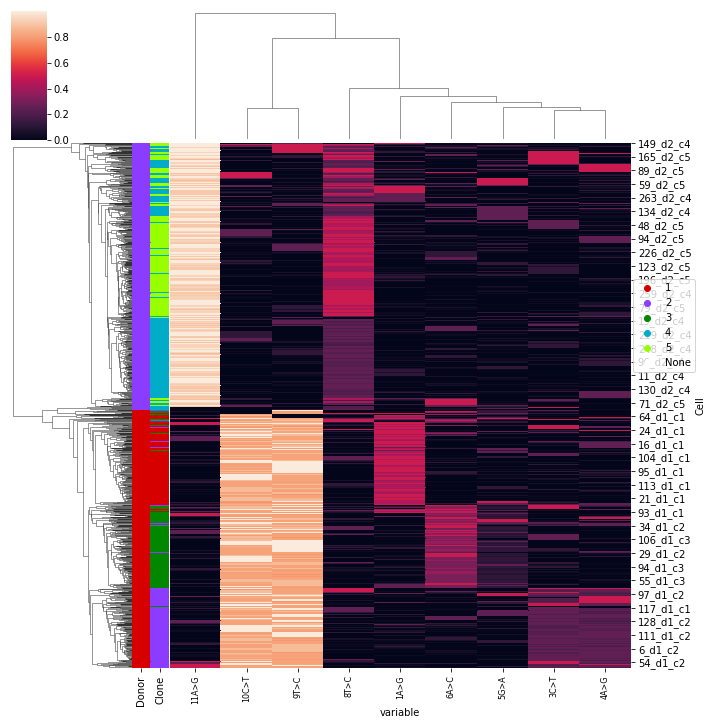

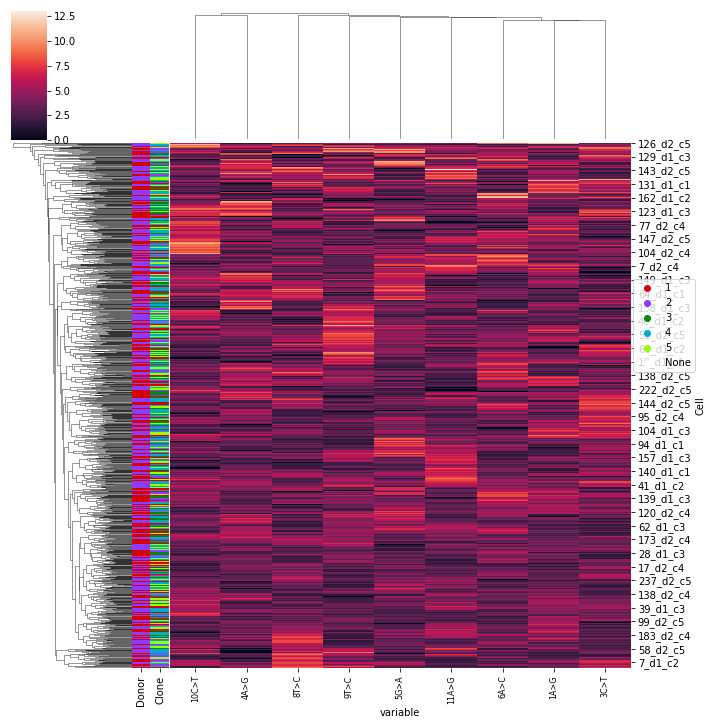

In [22]:
pre_AD_full = pre_AD.pivot(index="Cell", columns="variable", values="Counts").fillna(0).astype(int)
pre_DP_full = pre_DP.pivot(index="Cell", columns="variable", values="Counts").fillna(0).astype(int)
pre_AF_full = pre_AD_full/(pre_DP_full+0.001).astype(float)
pre_AF_full

## Create cell meta data
cells_meta = pd.DataFrame(list(map(lambda x: (int(x.split("_")[1][1:]), int(x.split("_")[2][1:])) ,pre_AF_full.index)), index=pre_AF_full.index, 
                          columns=["Donor", "Clone"])


## Plot cells AF and DP

plot_cluster(pre_AF_full, row_meta=cells_meta)

plot_cluster(np.log2(1+pre_DP_full), row_meta=cells_meta)

# Setup "Post" condition

In [23]:
# Setup culture condition
growth = {i:donor_cell_numbers[i]*clone_enrichment for i in donor_cell_numbers}
post_cells = {}
for d, c in cells_d.keys():
    post_cells[c] = clone_cell_numbers[c]*float(clone_enrichment.loc[c, "Enrichment"])
## Subset from each donor from each clone based on max cells
cond = "post"
vcf = pd.read_csv(cond_vcf_files[cond], sep='\t')
vcf["index"] = vcf.apply(lambda x: str(x["POS"]) + x["REF"]+">"+x["ALT"], axis=1) 
vcf["REF"] = vcf.apply(lambda x: str(x["POS"]) + x["REF"], axis=1) 
subset_inds = np.sort(np.random.choice(int(sum(post_cells.values())), 1000, replace=False))

count = 0
post_clone_cell_numbers_subset = {}
for c in post_cells:
    post_clone_cell_numbers_subset[c] = sum((subset_inds>=count)&(subset_inds<count+post_cells[c]))
    count += post_cells[c]
post_clone_cell_numbers_subset

# Create cell names with donor & clone information information. 
post_cells_d = {}
count = 0
for clone in post_clone_cell_numbers_subset:
    #curr_clones = clone_enrichment.loc[clone_enrichment.index==clone].index
    don = clone_enrichment.loc[clone, "Donor"]
    post_cells_d[(don, clone)] = list(map(lambda x: f"{x}_d{don}_c{clone}",np.arange(post_clone_cell_numbers_subset[clone])))



In [24]:
vcf

,#CHROM,POS,REF,ALT,index
0,chrM,1,1A,G,1A>G
1,chrM,2,2G,A,2G>A
2,chrM,6,6A,C,6A>C
3,chrM,7,7C,T,7C>T
4,chrM,8,8T,C,8T>C
5,chrM,9,9T,C,9T>C
6,chrM,10,10C,T,10C>T
7,chrM,11,11A,G,11A>G


In [25]:
print(post_clone_cell_numbers_subset)

[len(post_cells_d[x]) for x in post_cells_d]
 

{1: 181, 2: 25, 3: 89, 4: 580, 5: 125}


[181, 25, 89, 580, 125]

## Create dense dfs

In [26]:
# Setup initial matrix
post_AD = pd.DataFrame(index = functools.reduce(lambda a,b : a+b, post_cells_d.values()), columns=vcf["index"].values)
post_DP = pd.DataFrame(index = functools.reduce(lambda a,b : a+b, post_cells_d.values()), columns=vcf["index"].values)
post_AD.index = post_AD.index.rename("Cell")
post_DP.index = post_DP.index.rename("Cell")

for don in np.arange(1,num_donors+1): 
    print(don)
    post_don_num = donor_cell_numbers[don]
    post_clones = clone_enrichment.loc[clone_enrichment["Donor"]==don].index
    for clone, clone_df in clone_variant_means.loc[clone_variant_means.index.isin(post_clones)].iterrows():
        for variant, vaf in clone_df.iteritems():
            print(variant)
            if variant in vcf["index"].values:
                print('here')
                post_AD.loc[post_cells_d[don, clone], variant] = np.random.normal(loc=vaf, scale=0.01, size=len(post_cells_d[don, clone]))
                post_DP.loc[post_cells_d[don, clone], variant] = [2**x if x!= 0 else 0 for x in np.random.poisson(lam=4, size=len(post_cells_d[don, clone]))]
post_AD = post_AD.fillna(0)
post_AD[post_AD<0] = 0



1
1A>G
here
2G>A
here
3C>T
4A>G
5G>A
6A>C
here
7C>T
here
8T>C
here
9T>C
here
10C>T
here
11A>G
here
1A>G
here
2G>A
here
3C>T
4A>G
5G>A
6A>C
here
7C>T
here
8T>C
here
9T>C
here
10C>T
here
11A>G
here
1A>G
here
2G>A
here
3C>T
4A>G
5G>A
6A>C
here
7C>T
here
8T>C
here
9T>C
here
10C>T
here
11A>G
here
2
1A>G
here
2G>A
here
3C>T
4A>G
5G>A
6A>C
here
7C>T
here
8T>C
here
9T>C
here
10C>T
here
11A>G
here
1A>G
here
2G>A
here
3C>T
4A>G
5G>A
6A>C
here
7C>T
here
8T>C
here
9T>C
here
10C>T
here
11A>G
here


## Remap and create sparse

In [27]:
vars_int = {x:i+1 for i, x in enumerate(post_AD.columns)}
vars_int

{'1A>G': 1,
 '2G>A': 2,
 '6A>C': 3,
 '7C>T': 4,
 '8T>C': 5,
 '9T>C': 6,
 '10C>T': 7,
 '11A>G': 8}

In [28]:
cells_int = {}
count = 1
for k in post_cells_d:
    for cell in post_cells_d[k]:
        cells_int[cell] = count
        count+=1
# Create vars map:
    
post_AD = post_AD.reset_index().melt(id_vars="Cell", value_name="Counts")
post_DP = post_DP.reset_index().melt(id_vars="Cell", value_name="Counts")
print('post_AD melt')
print(post_AD.head())
post_AD["CB_index"] = post_AD["Cell"].map(cells_int)
post_DP["CB_index"] = post_DP["Cell"].map(cells_int)
post_AD["BC"] = post_AD["CB_index"].map(BCs)
post_DP["BC"] = post_DP["CB_index"].map(BCs)


post_AD melt
      Cell variable    Counts
0  0_d1_c1     1A>G  0.412855
1  1_d1_c1     1A>G  0.405787
2  2_d1_c1     1A>G  0.414645
3  3_d1_c1     1A>G  0.390235
4  4_d1_c1     1A>G  0.409565


In [29]:
post_AD

,Cell,variable,Counts,CB_index,BC
0,0_d1_c1,1A>G,0.412855,1,ATAATCGCTAGACGC-1
1,1_d1_c1,1A>G,0.405787,2,TCGCCTCAAACAACT-1
2,2_d1_c1,1A>G,0.414645,3,GCAATTCTATGAATG-1
3,3_d1_c1,1A>G,0.390235,4,AAAGGATAGCATGGT-1
4,4_d1_c1,1A>G,0.409565,5,GACGCATAAATTTCC-1
...,...,...,...,...,...
7995,120_d2_c5,11A>G,0.900236,996,TGGGGAGGAATGTTT-1
7996,121_d2_c5,11A>G,0.900912,997,GCTGGATCGGAAAGT-1
7997,122_d2_c5,11A>G,0.890639,998,ACAGACGGGTAGGTC-1
7998,123_d2_c5,11A>G,0.898167,999,CCTTCCGACTAACAA-1


In [30]:

post_AD["Var_index"] = post_AD["variable"].map(vars_int)
post_DP["Var_index"] = post_DP["variable"].map(vars_int)
print('post_AD reindex')
print(post_AD.head())

post_AD = post_AD.dropna().astype({"Var_index":int}) # Removes variants not in vcf
post_DP = post_DP.dropna().astype({"Var_index":int})

post_AD["Counts"] = np.ceil(post_AD["Counts"]*post_DP["Counts"]).astype(int)



post_AD reindex
      Cell variable    Counts  CB_index                 BC  Var_index
0  0_d1_c1     1A>G  0.412855         1  ATAATCGCTAGACGC-1          1
1  1_d1_c1     1A>G  0.405787         2  TCGCCTCAAACAACT-1          1
2  2_d1_c1     1A>G  0.414645         3  GCAATTCTATGAATG-1          1
3  3_d1_c1     1A>G  0.390235         4  AAAGGATAGCATGGT-1          1
4  4_d1_c1     1A>G  0.409565         5  GACGCATAAATTTCC-1          1



## Remove entries with 0s and assert no cell or variant is lost

In [31]:
post_AD = post_AD[~(post_AD["Counts"]== 0)]
post_DP = post_DP[~(post_DP["Counts"]== 0)]

print(post_DP.shape)
print(post_AD.shape)

assert(len(set(post_DP["Cell"]))==max(post_DP["CB_index"]))
assert(len(set(post_DP["variable"]))==max(post_DP["Var_index"]))

(7848, 6)
(5469, 6)


In [32]:

post_AD.to_csv(join(outdir, "post", "fullPost.AD.mtx"), sep='\t', index=False)
#post_AD.drop(["Cell", 'variable'], axis=1)[["CB_index", "Var_index", "Counts"]].to_csv(join(outdir, "post", "cellSNP.tag.AD.mtx"), sep='\t', header=None, index=False)
post_DP.to_csv(join(outdir, "post", "fullPost.DP.mtx"), sep='\t')
#post_DP.drop(["Cell", 'variable'], axis=1)[["CB_index", "Var_index", "Counts"]].to_csv(join(outdir, "post", "cellSNP.tag.DP.mtx"), sep='\t', header=None, index=False)

wrap_write_mtx_df(join(outdir, "post"), post_AD.drop(["Cell", 'variable', "BC"], axis=1), 
                  post_DP.drop(["Cell", 'variable', "BC"], axis=1), oth=None, to_rm=True,
                      prefix="cellSNP.tag",
                      columns=("Var_index", "CB_index", "Counts"))

vcf.to_csv(join(outdir, "post", "cellSNP.base.vcf"),sep='\t', index=False)
## Rename cells to similar BC format and save with same order
#post_BCs = [BCs[i] for i in np.arange(1,len(cells_int)+1)]
# with open(join(outdir, "post", "cellSNP.samples.tsv"),"w") as f:
#     f.write("\n".join(post_BCs))
post_BCs = {}
for bc, bc_ind in post_AD.groupby(["BC", "CB_index"]).groups.keys():
    post_BCs[bc_ind] = bc
post_BCs = pd.Series(post_BCs).sort_index()
post_BCs.to_csv(join(outdir, "post", "cellSNP.samples.tsv"), header=None, index=None)


cellSNP.tag


clustering
cmap None
clustering
cmap None


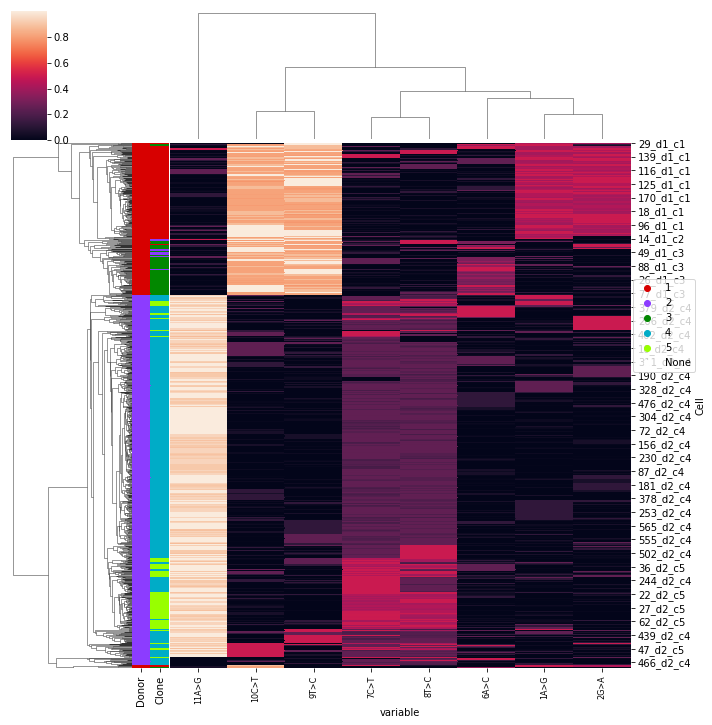

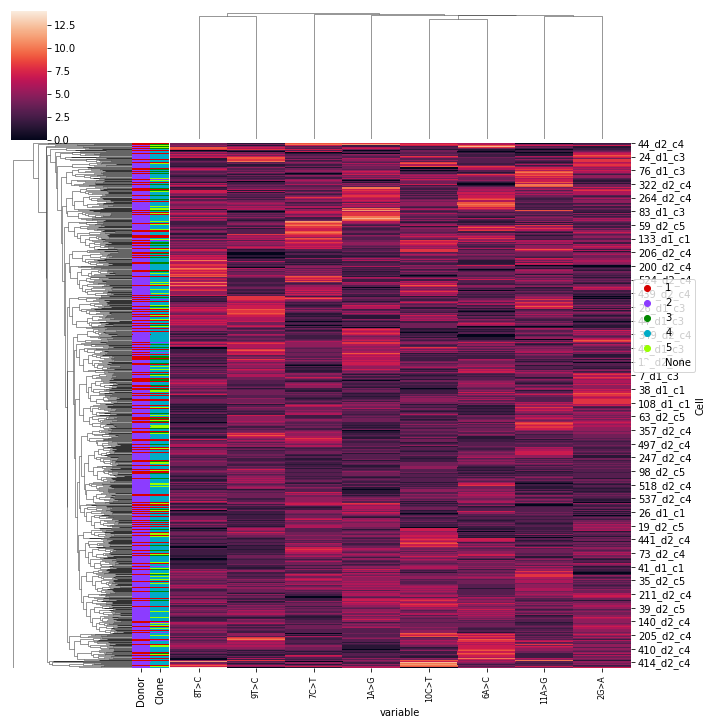

In [33]:
post_AD_full = post_AD.pivot(index="Cell", columns="variable", values="Counts").fillna(0).astype(int)
post_DP_full = post_DP.pivot(index="Cell", columns="variable", values="Counts").fillna(0).astype(int)
post_AF_full = post_AD_full/(post_DP_full+0.001).astype(float)
post_AF_full

## Create cell meta data
cells_meta = pd.DataFrame(list(map(lambda x: (int(x.split("_")[1][1:]), int(x.split("_")[2][1:])) ,post_AF_full.index)), index=post_AF_full.index, 
                          columns=["Donor", "Clone"])


## Plot cells AF and DP

plot_cluster(post_AF_full, row_meta=cells_meta)

plot_cluster(np.log2(1+post_DP_full), row_meta=cells_meta)